### Recreate figures from Fisher et al. (2018)

In [1]:
# Data processing
import iris
import iris.analysis
import iris.coord_categorisation
import warnings
warnings.filterwarnings('ignore', module='iris')
import numpy as np
from pathlib import Path
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
plt.rcParams['mathtext.default'] = 'regular'

In [2]:
# Path to data
path_to_ukca = Path.cwd().parent / 'raw'
# Path to figures
path_to_figs = Path.cwd().parent.parent.parent / 'results' / 'xojn' / 'Fisher2018-like'
path_to_figs.mkdir(exist_ok=True)

In [3]:
# Global variables
JOBS = {'BASE OLD':'xojnd',
        'BASE'    :'xojng',
        'CHEM'    :'xojnh',
        'MARI'    :'xojni',
        'FIRE'    :'xojnc',
        'FULL'    :'xojnl',
        'ORIG'    :'xolnb',
        'UPDT'    :'xolna'}
VARIABLES = {'molar_mass': {'o3':47.997, 'no':30.006, 'no2':46.006, 'hono':47.013, 'ho2no2':79.01224, 'hno3':63.012, 'n2o5':108.01, 
                            'pan':121.0489, 'ppan':135.0755,
                            'meono2':77.0394, 'etono2':91.0660, 'nprono2':105.0926, 'iprono2':105.0926,
                            'ch4':16.0425, 'c2h6':30.0690},
             'latex': {'o3':'$O_3$', 'no':'NO', 'no2':'$NO_2$', 'hono':'HONO', 'ho2no2':'$HO_2NO_2$', 'hno3':'$HNO_3$', 'n2o5':'N_2O_5', 
                       'pan':'PAN', 'ppan':'PPN', 
                       'nox':'$NO_x$', 'noy':'$NO_y$', 
                       'meono2':'$MeONO_2$', 'etono2':'$EtONO_2$', 'nprono2':'$nPrONO_2$', 'iprono2':'$iPrONO_2$', 'prono2':'$PrONO_2$',
                       'ch4':'$CH_4$', 'c2h6':'$C_2H_6$'}}
M_air = 28.97 # molar mass of dry air [g mol-1]

In [14]:
# Switches
exp = 'MARI'
var = 'noy'
savefig = False

job = JOBS[exp]

#### Annual means within 0-2, 2-6, 6-10 km (like Figure 2-4 in Fisher et al. (2018))

In [5]:
if var in ['meono2', 'etono2', 'nprono2', 'iprono2', 'prono2']:
    if var == 'prono2':
        cb1 = iris.load_cube(str(path_to_ukca / job / f'{job}_nprono2.nc'), 'nprono2')*(M_air/(VARIABLES['molar_mass']['nprono2']))*1e12
        cb2 = iris.load_cube(str(path_to_ukca / job / f'{job}_iprono2.nc'), 'iprono2')*(M_air/(VARIABLES['molar_mass']['iprono2']))*1e12
        cb = cb1.copy() + cb2.copy()
    else:
        cb = iris.load_cube(str(path_to_ukca / job / f'{job}_{var}.nc'), var)*(M_air/VARIABLES['molar_mass'][var])*1e12
    # Remove the first 2 years as a spin up
    cb = cb[24::,...] 
    # Add season and year coordinates
    iris.coord_categorisation.add_season(cb, 'time', name='season')
    iris.coord_categorisation.add_season_year(cb, 'time', name='year')
    # Simplify dimensions
    lons = cb.coord('longitude').points
    lats = cb.coord('latitude').points
    # Define constraints
    km_0_2 = iris.Constraint(level_height=lambda cell: 0 < cell.point < 2000) # 10
    km_2_6 = iris.Constraint(level_height=lambda cell: 2000 < cell.point < 6000) #  17
    km_6_10 = iris.Constraint(level_height=lambda cell: 6000 < cell.point < 10000) # 22
    # Extract and average data
    km_0_2_ann_ave = cb.extract(km_0_2).collapsed(['year', 'level_height'], iris.analysis.MEAN)
    km_2_6_ann_ave = cb.extract(km_2_6).collapsed(['year', 'level_height'], iris.analysis.MEAN)
    km_6_10_ann_ave = cb.extract(km_6_10).collapsed(['year', 'level_height'], iris.analysis.MEAN)
    # Add a cyclic point
    c_km_0_2_ann_ave, c_lons = cartopy.util.add_cyclic_point(km_0_2_ann_ave.data, coord=lons)
    c_km_2_6_ann_ave = cartopy.util.add_cyclic_point(km_2_6_ann_ave.data)
    c_km_6_10_ann_ave = cartopy.util.add_cyclic_point(km_6_10_ann_ave.data)
    # Choose colorbar scale
    cscale = 'sat' # 'saturated' or 'unsaturated'
    if cscale == 'sat':
        vmax0, vmax1, vmax2 = 10, 15, 20
        ticks0 = [0, 5, 10]
        ticks1 = [0, 7.5, 15]
        ticks2 = [0, 10, 20]
    else:
        vmax0, vmax1, vmax2 = 40, 60, 80
        ticks0 = [0, 20, 40]
        ticks1 = [0, 30, 60]
        ticks2 = [0, 40, 80]

In [6]:
if var in ['meono2', 'etono2', 'nprono2', 'iprono2', 'prono2']:
    plt.rcParams['axes.titlesize'] = 26
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['font.size'] = 18
    # Plot annual mean within 0-2, 2-6, 6-10 km
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,16), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=230)), facecolor='w')
    p0 = ax[0].pcolormesh(c_lons, lats, c_km_6_10_ann_ave.data, vmin=0, vmax=vmax0, transform=ccrs.PlateCarree())
    p1 = ax[1].pcolormesh(c_lons, lats, c_km_2_6_ann_ave.data, vmin=0, vmax=vmax1, transform=ccrs.PlateCarree())
    p2 = ax[2].pcolormesh(c_lons, lats, c_km_0_2_ann_ave.data, vmin=0, vmax=vmax2, transform=ccrs.PlateCarree())
    cb0 = fig.colorbar(p0, ax=ax[0], ticks=ticks0)
    cb1 = fig.colorbar(p1, ax=ax[1], ticks=ticks1)
    cb2 = fig.colorbar(p2, ax=ax[2], ticks=ticks2)
    fig.text(0.84, 0.873, 'pptv', fontsize=20)
    ax[0].add_artist(AnchoredText('6-10 km', loc='lower left', bbox_to_anchor=(-0.03, 0.85), bbox_transform=ax[0].transAxes, frameon=False))
    ax[1].add_artist(AnchoredText('2-6 km', loc='lower left', bbox_to_anchor=(-0.03, 0.85), bbox_transform=ax[1].transAxes, frameon=False))
    ax[2].add_artist(AnchoredText('0-2 km', loc='lower left', bbox_to_anchor=(-0.03, 0.85), bbox_transform=ax[2].transAxes, frameon=False))
    ax[0].set_title(f'UM-UKCA {exp}', loc='left', weight='bold', fontsize=20)
    ax[0].set_title(VARIABLES['latex'][var], loc='center')
    for iax in ax.flatten(): iax.coastlines()
    fig.subplots_adjust(hspace=0.1)
    if savefig: fig.savefig(path_to_figs / f'Fisher2018-like_{exp.lower()}_{var}_{cscale}.png', bbox_inches='tight')

#### Zonal seasonal means below 12 km within 180-130W (like Figure 5 in Fisher et al. (2018))

In [7]:
if var == 'rono2':
    # Read data
    cb1 = iris.load_cube(str(path_to_ukca / job / f'{job}_meono2.nc'), 'meono2')*(M_air/(VARIABLES['molar_mass']['meono2']))*1e12
    cb2 = iris.load_cube(str(path_to_ukca / job / f'{job}_etono2.nc'), 'etono2')*(M_air/(VARIABLES['molar_mass']['etono2']))*1e12
    cb3 = iris.load_cube(str(path_to_ukca / job / f'{job}_nprono2.nc'), 'nprono2')*(M_air/(VARIABLES['molar_mass']['nprono2']))*1e12
    cb4 = iris.load_cube(str(path_to_ukca / job / f'{job}_iprono2.nc'), 'iprono2')*(M_air/(VARIABLES['molar_mass']['iprono2']))*1e12
    cb = cb1.copy() + cb2.copy() + cb3.copy() + cb4.copy()
    # Remove the first 2 years as a spin up
    cb = cb[24::,...] 
    # Add season and year coordinates
    iris.coord_categorisation.add_season(cb, 'time', name='season')
    iris.coord_categorisation.add_season_year(cb, 'time', name='year')
    # Simplify dimensions
    lons = cb.coord('longitude').points
    lats = cb.coord('latitude').points
    # Define constraints
    pacific = iris.Constraint(longitude=lambda cell: 180 < cell < 230)
    below_12_km = iris.Constraint(level_height=lambda cell: 0 < cell.point < 12000) # mid 11520.002, bounds = [11049.996, 12009.998]
    winter = iris.Constraint(season='djf')
    spring = iris.Constraint(season='mam')
    summer = iris.Constraint(season='jja')
    autumn = iris.Constraint(season='son')
    # Extract data
    pac_znl_djf = cb.extract(pacific & below_12_km & winter)
    pac_znl_mam = cb.extract(pacific & below_12_km & spring)
    pac_znl_jja = cb.extract(pacific & below_12_km & summer)
    pac_znl_son = cb.extract(pacific & below_12_km & autumn)
    # Average data
    pac_znl_djf_ave = pac_znl_djf.collapsed(['longitude', 'season'], iris.analysis.MEAN)
    pac_znl_mam_ave = pac_znl_mam.collapsed(['longitude', 'season'], iris.analysis.MEAN)
    pac_znl_jja_ave = pac_znl_jja.collapsed(['longitude', 'season'], iris.analysis.MEAN)
    pac_znl_son_ave = pac_znl_son.collapsed(['longitude', 'season'], iris.analysis.MEAN)
    # Merge two colormaps: color values present in GEOS-Chem and UM-UKCA using one colormap and UM-UKCA higher than GEOS-Chem using another colormap
    class MidpointNormalize(colors.Normalize):
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            colors.Normalize.__init__(self, vmin, vmax, clip)
        def __call__(self, value, clip=None):
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y))
    colors_low = plt.cm.viridis(np.linspace(0,1,128))
    colors_high = plt.cm.autumn_r(np.linspace(0,1,128))
    colors_stack = np.vstack((colors_low, colors_high))
    mrgd_cmap = colors.LinearSegmentedColormap.from_list('merged_cmap', colors_stack)

In [8]:
if var == 'rono2':
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['font.size'] = 14
    # Plot zonal seasonal means below 12 km within 130-180W 
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(9,13.9), facecolor='w', sharex=True)
    levs = pac_znl_djf.coord('level_height').points/1000
    p0 = ax[0].pcolormesh(lats, levs, pac_znl_djf_ave.data, norm=MidpointNormalize(midpoint=30), cmap=mrgd_cmap, vmin=0)
    p1 = ax[1].pcolormesh(lats, levs, pac_znl_mam_ave.data, norm=MidpointNormalize(midpoint=30), cmap=mrgd_cmap, vmin=0)
    p2 = ax[2].pcolormesh(lats, levs, pac_znl_jja_ave.data, norm=MidpointNormalize(midpoint=30), cmap=mrgd_cmap, vmin=0)
    p3 = ax[3].pcolormesh(lats, levs, pac_znl_son_ave.data, norm=MidpointNormalize(midpoint=30), cmap=mrgd_cmap, vmin=0)

    cax = fig.add_axes([0.125, 0.06, 0.773, 0.02]) # [left, bottom, width, height]
    cbar = fig.colorbar(p3, cax=cax, orientation='horizontal') #, extend='max')
    fig.text(0.91, 0.041, 'pptv')
    # cmap = plt.cm.get_cmap('viridis')
    # cmap.set_over('gold')

    c0 = ax[0].contour(lats, levs, pac_znl_djf_ave.data, levels=[30], colors='w')
    c1 = ax[1].contour(lats, levs, pac_znl_mam_ave.data, levels=[30], colors='w')
    c2 = ax[2].contour(lats, levs, pac_znl_jja_ave.data, levels=[30], colors='w')
    c3 = ax[3].contour(lats, levs, pac_znl_son_ave.data, levels=[30], colors='w')

    ax[0].add_artist(AnchoredText('DJF', loc=2, frameon=False, prop=dict(color='w', fontweight='bold')))
    ax[1].add_artist(AnchoredText('MAM', loc=2, frameon=False, prop=dict(color='w', fontweight='bold')))
    ax[2].add_artist(AnchoredText('JJA', loc=2, frameon=False, prop=dict(color='w', fontweight='bold')))
    ax[3].add_artist(AnchoredText('SON', loc=2, frameon=False, prop=dict(color='w', fontweight='bold')))

    ax[0].set_title(u'$C_1$-$C_3$ $RONO_2$ (130-180\u00b0W)', loc='center')
    ax[0].set_title(f'UM-UKCA {exp}', loc='left', weight='bold', fontsize=13)
    ax[3].set_xlabel('Latitude')
    ax[3].set_xticks([-90, -60, -30, 0, 30, 60, 90])
    for iax in ax[0:3].flatten(): iax.xaxis.set_ticks_position('none')
    for iax in ax.flatten():
        iax.set_ylabel('Altutude (km)')
        for c in [c0, c1, c2, c3]: 
            iax.clabel(c, fmt='%2i', colors='w')
    fig.subplots_adjust(hspace=0.035)
    if savefig: fig.savefig(path_to_figs / f'Fisher2018-like_{exp.lower()}_{var}.png', bbox_inches='tight')

#### Annual mean BL and FT differences in NOx, NOy, PAN, O3 (like Figure 6 in Fisher et al. (2018))

In [9]:
if var == 'diffs':
    # Read data
    base_exp = 'BASE'
    base_job = JOBS[base_exp]
    base_no = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_no.nc'), 'no')*(M_air/(VARIABLES['molar_mass']['no']))*1e12
    base_no2 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_no2.nc'), 'no2')*(M_air/(VARIABLES['molar_mass']['no2']))*1e12
    base_hono = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_hono.nc'), 'hono')*(M_air/(VARIABLES['molar_mass']['hono']))*1e12
    base_ho2no2 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_ho2no2.nc'), 'ho2no2')*(M_air/(VARIABLES['molar_mass']['ho2no2']))*1e12
    base_hno3 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_hno3.nc'), 'hno3')*(M_air/(VARIABLES['molar_mass']['hno3']))*1e12
    base_n2o5 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_n2o5.nc'), 'n2o5')*(M_air/(VARIABLES['molar_mass']['n2o5']))*1e12
    base_pan = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_pan.nc'), 'pan')*(M_air/(VARIABLES['molar_mass']['pan']))*1e12
    base_ppan = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_ppan.nc'), 'ppan')*(M_air/(VARIABLES['molar_mass']['ppan']))*1e12
    base_meono2 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_meono2.nc'), 'meono2')*(M_air/(VARIABLES['molar_mass']['meono2']))*1e12
    base_etono2 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_etono2.nc'), 'etono2')*(M_air/(VARIABLES['molar_mass']['etono2']))*1e12
    base_nprono2 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_nprono2.nc'), 'nprono2')*(M_air/(VARIABLES['molar_mass']['nprono2']))*1e12
    base_iprono2 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_iprono2.nc'), 'iprono2')*(M_air/(VARIABLES['molar_mass']['iprono2']))*1e12
    base_o3 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_o3.nc'), 'o3')*(M_air/(VARIABLES['molar_mass']['o3']))*1e9

    sens_no = iris.load_cube(str(path_to_ukca / job / f'{job}_no.nc'), 'no')*(M_air/(VARIABLES['molar_mass']['no']))*1e12
    sens_no2 = iris.load_cube(str(path_to_ukca / job / f'{job}_no2.nc'), 'no2')*(M_air/(VARIABLES['molar_mass']['no2']))*1e12
    sens_hono = iris.load_cube(str(path_to_ukca / job / f'{job}_hono.nc'), 'hono')*(M_air/(VARIABLES['molar_mass']['hono']))*1e12
    sens_ho2no2 = iris.load_cube(str(path_to_ukca / job / f'{job}_ho2no2.nc'), 'ho2no2')*(M_air/(VARIABLES['molar_mass']['ho2no2']))*1e12
    sens_hno3 = iris.load_cube(str(path_to_ukca / job / f'{job}_hno3.nc'), 'hno3')*(M_air/(VARIABLES['molar_mass']['hno3']))*1e12
    sens_n2o5 = iris.load_cube(str(path_to_ukca / job / f'{job}_n2o5.nc'), 'n2o5')*(M_air/(VARIABLES['molar_mass']['n2o5']))*1e12
    sens_pan = iris.load_cube(str(path_to_ukca / job / f'{job}_pan.nc'), 'pan')*(M_air/(VARIABLES['molar_mass']['pan']))*1e12
    sens_ppan = iris.load_cube(str(path_to_ukca / job / f'{job}_ppan.nc'), 'ppan')*(M_air/(VARIABLES['molar_mass']['ppan']))*1e12
    sens_meono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_meono2.nc'), 'meono2')*(M_air/(VARIABLES['molar_mass']['meono2']))*1e12
    sens_etono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_etono2.nc'), 'etono2')*(M_air/(VARIABLES['molar_mass']['etono2']))*1e12
    sens_nprono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_nprono2.nc'), 'nprono2')*(M_air/(VARIABLES['molar_mass']['nprono2']))*1e12
    sens_iprono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_iprono2.nc'), 'iprono2')*(M_air/(VARIABLES['molar_mass']['iprono2']))*1e12
    sens_o3 = iris.load_cube(str(path_to_ukca / job / f'{job}_o3.nc'), 'o3')*(M_air/(VARIABLES['molar_mass']['o3']))*1e9

    base_nox = base_no.copy() + base_no2.copy()
    base_noy = base_no.copy() + base_no2.copy() + base_hono.copy() + base_ho2no2.copy() + base_hno3.copy() + base_n2o5.copy() + base_pan.copy() + base_ppan.copy() + base_meono2.copy() + base_etono2.copy() + base_nprono2.copy() + base_iprono2.copy()
    sens_nox = sens_no.copy() + sens_no2.copy()
    sens_noy = sens_no.copy() + sens_no2.copy() + sens_hono.copy() + sens_ho2no2.copy() + sens_hno3.copy() + sens_n2o5.copy() + sens_pan.copy() + sens_ppan.copy() + sens_meono2.copy() + sens_etono2.copy() + sens_nprono2.copy() + sens_iprono2.copy()
    # Remove the first 2 years as a spin up
    base_nox = base_nox[24:,...]
    base_noy = base_noy[24:,...]
    base_pan = base_pan[24:,...]
    base_o3 = base_o3[24:,...]

    sens_nox = sens_nox[24:,...]
    sens_noy = sens_noy[24:,...]
    sens_pan = sens_pan[24:,...]
    sens_o3 = sens_o3[24:,...]
    # Add season and year coordinates
    for icb in [base_nox, base_noy, base_pan, base_o3, sens_nox, sens_noy, sens_pan, sens_o3]:
        iris.coord_categorisation.add_season(icb, 'time', name='season')
        iris.coord_categorisation.add_season_year(icb, 'time', name='year')
    # Simplify dimensions
    lons = base_no.coord('longitude').points
    lats = base_no.coord('latitude').points
    # Define constraints
    pbl = iris.Constraint(level_height=lambda cell: 0 < cell.point < 2000)
    ftr = iris.Constraint(level_height=lambda cell: 5000 < cell.point < 10000)
    # Extract and average data
    base_nox_pbl_ann = base_nox.extract(pbl).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    base_noy_pbl_ann = base_noy.extract(pbl).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    base_pan_pbl_ann = base_pan.extract(pbl).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    base_o3_pbl_ann = base_o3.extract(pbl).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    sens_nox_pbl_ann = sens_nox.extract(pbl).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    sens_noy_pbl_ann = sens_noy.extract(pbl).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    sens_pan_pbl_ann = sens_pan.extract(pbl).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    sens_o3_pbl_ann = sens_o3.extract(pbl).collapsed(['level_height', 'year'], iris.analysis.MEAN)

    base_nox_ftr_ann = base_nox.extract(ftr).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    base_noy_ftr_ann = base_noy.extract(ftr).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    base_pan_ftr_ann = base_pan.extract(ftr).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    base_o3_ftr_ann = base_o3.extract(ftr).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    sens_nox_ftr_ann = sens_nox.extract(ftr).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    sens_noy_ftr_ann = sens_noy.extract(ftr).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    sens_pan_ftr_ann = sens_pan.extract(ftr).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    sens_o3_ftr_ann = sens_o3.extract(ftr).collapsed(['level_height', 'year'], iris.analysis.MEAN)
    # Find absolute difference
    nox_pbl_ann_abs_diff = sens_nox_pbl_ann - base_nox_pbl_ann
    noy_pbl_ann_abs_diff = sens_noy_pbl_ann - base_noy_pbl_ann
    pan_pbl_ann_abs_diff = sens_pan_pbl_ann - base_pan_pbl_ann
    o3_pbl_ann_abs_diff = sens_o3_pbl_ann - base_o3_pbl_ann

    nox_ftr_ann_abs_diff = sens_nox_ftr_ann - base_nox_ftr_ann
    noy_ftr_ann_abs_diff = sens_noy_ftr_ann - base_noy_ftr_ann
    pan_ftr_ann_abs_diff = sens_pan_ftr_ann - base_pan_ftr_ann
    o3_ftr_ann_abs_diff = sens_o3_ftr_ann - base_o3_ftr_ann
    # Find relative difference
    nox_pbl_ann_pct_diff = nox_pbl_ann_abs_diff/base_nox_pbl_ann*100
    noy_pbl_ann_pct_diff = noy_pbl_ann_abs_diff/base_noy_pbl_ann*100
    pan_pbl_ann_pct_diff = pan_pbl_ann_abs_diff/base_pan_pbl_ann*100
    o3_pbl_ann_pct_diff = o3_pbl_ann_abs_diff/base_o3_pbl_ann*100

    nox_ftr_ann_pct_diff = nox_ftr_ann_abs_diff/base_nox_ftr_ann*100
    noy_ftr_ann_pct_diff = noy_ftr_ann_abs_diff/base_noy_ftr_ann*100
    pan_ftr_ann_pct_diff = pan_ftr_ann_abs_diff/base_pan_ftr_ann*100
    o3_ftr_ann_pct_diff = o3_ftr_ann_abs_diff/base_o3_ftr_ann*100
    # Add a cyclic point
    c_nox_pbl_ann_abs_diff, c_lons = cartopy.util.add_cyclic_point(nox_pbl_ann_abs_diff.data, coord=lons)
    c_noy_pbl_ann_abs_diff = cartopy.util.add_cyclic_point(noy_pbl_ann_abs_diff.data)
    c_pan_pbl_ann_abs_diff = cartopy.util.add_cyclic_point(pan_pbl_ann_abs_diff.data)
    c_o3_pbl_ann_abs_diff = cartopy.util.add_cyclic_point(o3_pbl_ann_abs_diff.data)

    c_nox_ftr_ann_abs_diff, c_lons = cartopy.util.add_cyclic_point(nox_ftr_ann_abs_diff.data, coord=lons)
    c_noy_ftr_ann_abs_diff = cartopy.util.add_cyclic_point(noy_ftr_ann_abs_diff.data)
    c_pan_ftr_ann_abs_diff = cartopy.util.add_cyclic_point(pan_ftr_ann_abs_diff.data)
    c_o3_ftr_ann_abs_diff = cartopy.util.add_cyclic_point(o3_ftr_ann_abs_diff.data)
    
    
    c_nox_pbl_ann_pct_diff, c_lons = cartopy.util.add_cyclic_point(nox_pbl_ann_pct_diff.data, coord=lons)
    c_noy_pbl_ann_pct_diff = cartopy.util.add_cyclic_point(noy_pbl_ann_pct_diff.data)
    c_pan_pbl_ann_pct_diff = cartopy.util.add_cyclic_point(pan_pbl_ann_pct_diff.data)
    c_o3_pbl_ann_pct_diff = cartopy.util.add_cyclic_point(o3_pbl_ann_pct_diff.data)

    c_nox_ftr_ann_pct_diff, c_lons = cartopy.util.add_cyclic_point(nox_ftr_ann_pct_diff.data, coord=lons)
    c_noy_ftr_ann_pct_diff = cartopy.util.add_cyclic_point(noy_ftr_ann_pct_diff.data)
    c_pan_ftr_ann_pct_diff = cartopy.util.add_cyclic_point(pan_ftr_ann_pct_diff.data)
    c_o3_ftr_ann_pct_diff = cartopy.util.add_cyclic_point(o3_ftr_ann_pct_diff.data)

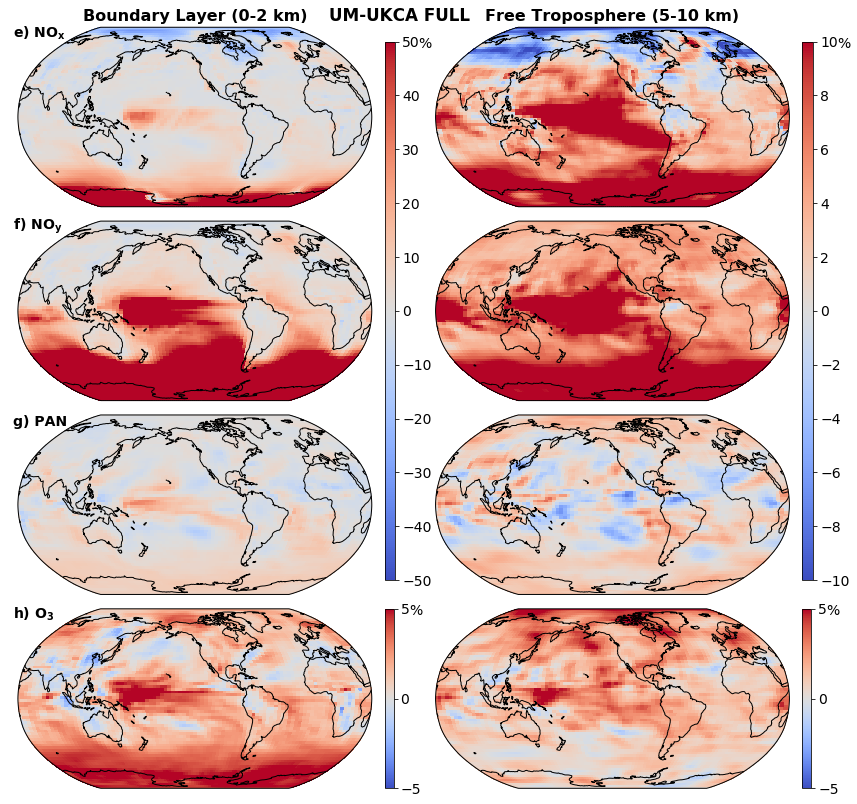

In [10]:
if var == 'diffs':
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['font.size'] = 14
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(19,14), facecolor='w',
                           subplot_kw=dict(projection=ccrs.Robinson(central_longitude=230)), gridspec_kw=dict(hspace=0.08, wspace=-0.35))
    p00 = ax[0,0].pcolormesh(c_lons, lats, c_nox_pbl_ann_pct_diff.data, vmin=-50, vmax=50, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p10 = ax[1,0].pcolormesh(c_lons, lats, c_noy_pbl_ann_pct_diff.data, vmin=-50, vmax=50, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p20 = ax[2,0].pcolormesh(c_lons, lats, c_pan_pbl_ann_pct_diff.data, vmin=-50, vmax=50, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p30 = ax[3,0].pcolormesh(c_lons, lats, c_o3_pbl_ann_pct_diff.data, vmin=-5, vmax=5, transform=ccrs.PlateCarree(), cmap='coolwarm')

    p01 = ax[0,1].pcolormesh(c_lons, lats, c_nox_ftr_ann_pct_diff.data, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p11 = ax[1,1].pcolormesh(c_lons, lats, c_noy_ftr_ann_pct_diff.data, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p21 = ax[2,1].pcolormesh(c_lons, lats, c_pan_ftr_ann_pct_diff.data, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p31 = ax[3,1].pcolormesh(c_lons, lats, c_o3_ftr_ann_pct_diff.data, vmin=-5, vmax=5, transform=ccrs.PlateCarree(), cmap='coolwarm')

    cb00 = fig.colorbar(p00, ax=ax[0,0], ticks=np.arange(-50,60,10), shrink=3, aspect=50, pad=0.02)
    cb20 = fig.colorbar(p20, ax=ax[2,0], ticks=np.arange(-50,60,10), shrink=3, aspect=50, pad=0.02)
    cb01 = fig.colorbar(p01, ax=ax[0,1], ticks=np.arange(-10,15,5), shrink=3, aspect=50, pad=0.02)
    cb21 = fig.colorbar(p21, ax=ax[2,1], ticks=np.arange(-10,15,5), shrink=3, aspect=50, pad=0.02)
    cb00.remove()
    cb20.remove()
    cb01.remove()
    cb21.remove()
    plt.draw() # update plot

    cb10 = fig.colorbar(p10, ax=ax[1,0], ticks=np.arange(-50,60,10), shrink=3, aspect=50, pad=0.02)
    cb30 = fig.colorbar(p30, ax=ax[3,0], ticks=np.arange(-5,10,5), pad=0.02)
    cb11 = fig.colorbar(p11, ax=ax[1,1], ticks=np.arange(-10,12,2), shrink=3, aspect=50, pad=0.02)
    cb31 = fig.colorbar(p31, ax=ax[3,1], ticks=np.arange(-5,10,5), pad=0.02)
    fig.text(0.549, 0.86, '%')
    fig.text(0.855, 0.86, '%')
    fig.text(0.542, 0.297, '%')
    fig.text(0.847, 0.297, '%')

    ax[0,0].set_title('Boundary Layer (0-2 km)', weight='bold')
    ax[0,1].set_title('Free Troposphere (5-10 km)', weight='bold')
    ax[0,0].add_artist(AnchoredText('e) $NO_x$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[0,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[1,0].add_artist(AnchoredText('f) $NO_y$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[1,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[2,0].add_artist(AnchoredText('g) PAN', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[2,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[3,0].add_artist(AnchoredText('h) $O_3$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[3,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    for iax in ax.flatten(): iax.coastlines();
    fig.suptitle(f'UM-UKCA {exp}', weight='bold', x=0.535, y=0.9);
    if savefig: fig.savefig(path_to_figs / f'Fisher2018-like_{exp.lower()}_pbl_ftr_{var}_pct.png', bbox_inches='tight')

In [11]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

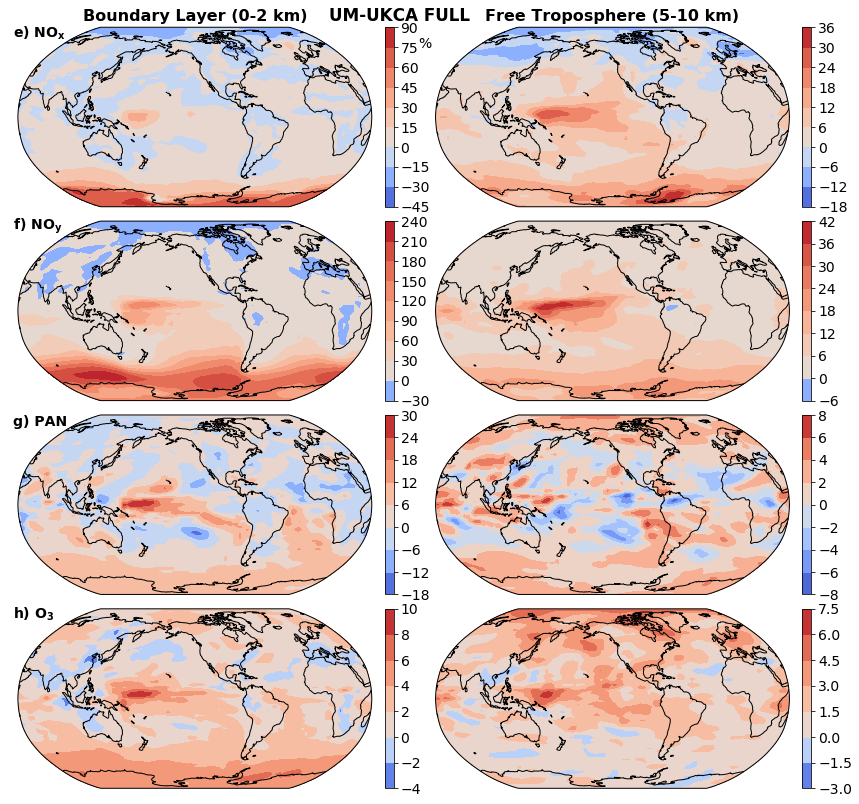

In [12]:
# Relative differences with individual colorbars
if var == 'diffs':
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['font.size'] = 14
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(19,14), facecolor='w',
                           subplot_kw=dict(projection=ccrs.Robinson(central_longitude=230)), gridspec_kw=dict(hspace=0.08, wspace=-0.35))
    p00 = ax[0,0].contourf(c_lons, lats, c_nox_pbl_ann_pct_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p10 = ax[1,0].contourf(c_lons, lats, c_noy_pbl_ann_pct_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p20 = ax[2,0].contourf(c_lons, lats, c_pan_pbl_ann_pct_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p30 = ax[3,0].contourf(c_lons, lats, c_o3_pbl_ann_pct_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    
#     ax[1,0].contour(c_lons, lats, c_noy_pbl_ann_pct_diff.data, levels=[-5], transform=ccrs.PlateCarree(), cmap='coolwarm')

    p01 = ax[0,1].contourf(c_lons, lats, c_nox_ftr_ann_pct_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p11 = ax[1,1].contourf(c_lons, lats, c_noy_ftr_ann_pct_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p21 = ax[2,1].contourf(c_lons, lats, c_pan_ftr_ann_pct_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p31 = ax[3,1].contourf(c_lons, lats, c_o3_ftr_ann_pct_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    
#     ax[1,1].contour(c_lons, lats, c_noy_ftr_ann_pct_diff.data, levels=[10,24], transform=ccrs.PlateCarree(), cmap='coolwarm')

    cb00 = fig.colorbar(p00, ax=ax[0,0], pad=0.02)
    cb01 = fig.colorbar(p01, ax=ax[0,1], pad=0.02)
    cb10 = fig.colorbar(p10, ax=ax[1,0], pad=0.02)
    cb11 = fig.colorbar(p11, ax=ax[1,1], pad=0.02)
    cb20 = fig.colorbar(p20, ax=ax[2,0], pad=0.02)
    cb21 = fig.colorbar(p21, ax=ax[2,1], pad=0.02)
    cb30 = fig.colorbar(p30, ax=ax[3,0], pad=0.02)
    cb31 = fig.colorbar(p31, ax=ax[3,1], pad=0.02)
    fig.text(0.549, 0.86, '%')
#     fig.text(0.855, 0.86, '%')
#     fig.text(0.542, 0.297, '%')
#     fig.text(0.847, 0.297, '%')

    ax[0,0].set_title('Boundary Layer (0-2 km)', weight='bold')
    ax[0,1].set_title('Free Troposphere (5-10 km)', weight='bold')
    ax[0,0].add_artist(AnchoredText('e) $NO_x$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[0,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[1,0].add_artist(AnchoredText('f) $NO_y$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[1,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[2,0].add_artist(AnchoredText('g) PAN', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[2,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[3,0].add_artist(AnchoredText('h) $O_3$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[3,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    for iax in ax.flatten(): iax.coastlines();
    fig.suptitle(f'UM-UKCA {exp}', weight='bold', x=0.535, y=0.9);
    if savefig: fig.savefig(path_to_figs / f'Fisher2018-like_{exp.lower()}_pbl_ftr_{var}_pct_diffcbar.png', bbox_inches='tight')

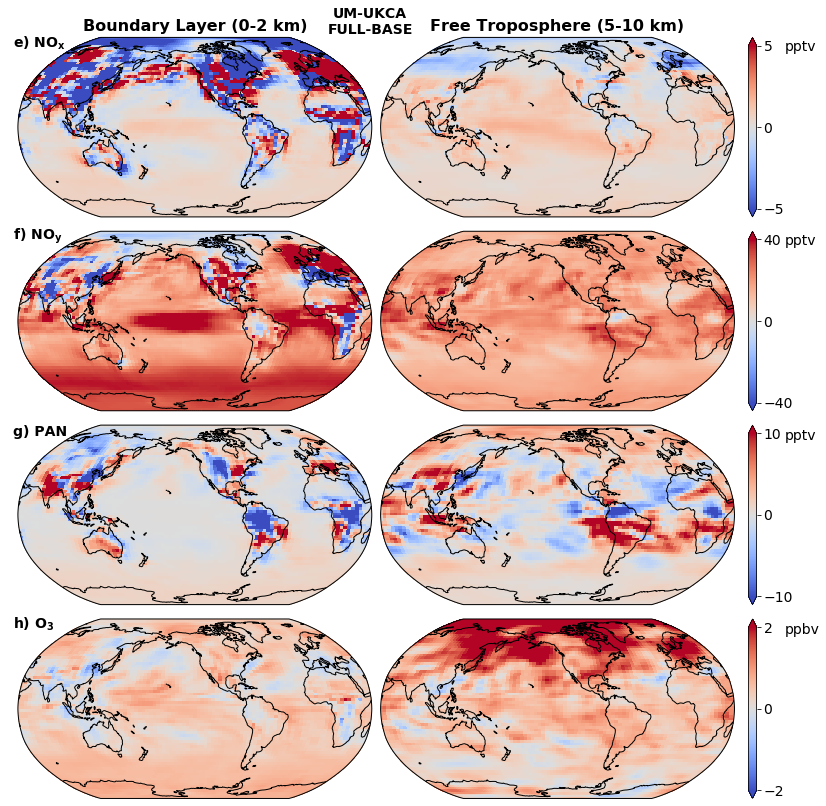

In [13]:
# Absolute differences
if var == 'diffs':
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['font.size'] = 14
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(19,14), facecolor='w',
                           subplot_kw=dict(projection=ccrs.Robinson(central_longitude=230)), gridspec_kw=dict(hspace=0.08, wspace=-0.48))
    p00 = ax[0,0].pcolormesh(c_lons, lats, c_nox_pbl_ann_abs_diff.data, vmin=-5, vmax=5, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p10 = ax[1,0].pcolormesh(c_lons, lats, c_noy_pbl_ann_abs_diff.data, vmin=-40, vmax=40, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p20 = ax[2,0].pcolormesh(c_lons, lats, c_pan_pbl_ann_abs_diff.data, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p30 = ax[3,0].pcolormesh(c_lons, lats, c_o3_pbl_ann_abs_diff.data, vmin=-2, vmax=2, transform=ccrs.PlateCarree(), cmap='coolwarm')
    
#     ax[1,0].contour(c_lons, lats, c_noy_pbl_ann_abs_diff.data, levels=[-5], transform=ccrs.PlateCarree(), cmap='coolwarm')

    p01 = ax[0,1].pcolormesh(c_lons, lats, c_nox_ftr_ann_abs_diff.data, vmin=-5, vmax=5, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p11 = ax[1,1].pcolormesh(c_lons, lats, c_noy_ftr_ann_abs_diff.data, vmin=-40, vmax=40, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p21 = ax[2,1].pcolormesh(c_lons, lats, c_pan_ftr_ann_abs_diff.data, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), cmap='coolwarm')
    p31 = ax[3,1].pcolormesh(c_lons, lats, c_o3_ftr_ann_abs_diff.data, vmin=-2, vmax=2, transform=ccrs.PlateCarree(), cmap='coolwarm')
    
#     ax[1,1].contour(c_lons, lats, c_noy_ftr_ann_abs_diff.data, levels=[10,24], transform=ccrs.PlateCarree(), cmap='coolwarm')

    cb00 = fig.colorbar(p00, ax=ax[0,0], pad=0.02, extend='both')
    cb01 = fig.colorbar(p01, ax=ax[0,1], pad=0.02, extend='both', ticks=np.arange(-5,10,5))
    cb10 = fig.colorbar(p10, ax=ax[1,0], pad=0.02, extend='both')
    cb11 = fig.colorbar(p11, ax=ax[1,1], pad=0.02, extend='both', ticks=np.arange(-40,80,40))
    cb20 = fig.colorbar(p20, ax=ax[2,0], pad=0.02, extend='both')
    cb21 = fig.colorbar(p21, ax=ax[2,1], pad=0.02, extend='both', ticks=np.arange(-10,20,10))
    cb30 = fig.colorbar(p30, ax=ax[3,0], pad=0.02, extend='both')
    cb31 = fig.colorbar(p31, ax=ax[3,1], pad=0.02, extend='both', ticks=np.arange(-2,4,2))
    cb00.remove()
    cb10.remove()
    cb20.remove()
    cb30.remove()
    plt.draw() # update plot
    fig.text(0.850, 0.867, 'pptv')
    fig.text(0.850, 0.674, 'pptv')
    fig.text(0.850, 0.481, 'pptv')
    fig.text(0.850, 0.288, 'ppbv')

    ax[0,0].set_title('Boundary Layer (0-2 km)', weight='bold')
    ax[0,1].set_title('Free Troposphere (5-10 km)', weight='bold')
    ax[0,0].add_artist(AnchoredText('e) $NO_x$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[0,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[1,0].add_artist(AnchoredText('f) $NO_y$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[1,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[2,0].add_artist(AnchoredText('g) PAN', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[2,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[3,0].add_artist(AnchoredText('h) $O_3$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[3,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    for iax in ax.flatten(): iax.coastlines();
    fig.suptitle(f'UM-UKCA\n{exp}-BASE', weight='bold', x=0.547, y=0.91, fontsize=14);
    if savefig: fig.savefig(path_to_figs / f'Fisher2018-like_{exp.lower()}_pbl_ftr_{var}_abs.png', bbox_inches='tight')

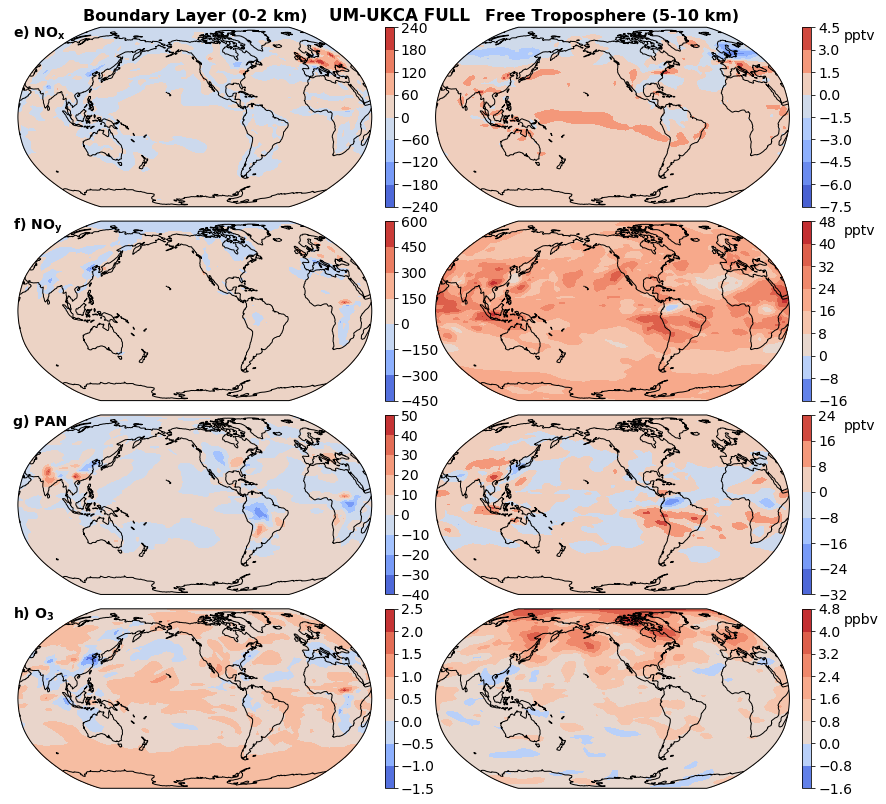

In [14]:
# Absolute differences with individual colorbars
if var == 'diffs':
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['font.size'] = 14
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(19,14), facecolor='w',
                           subplot_kw=dict(projection=ccrs.Robinson(central_longitude=230)), gridspec_kw=dict(hspace=0.08, wspace=-0.35))
    p00 = ax[0,0].contourf(c_lons, lats, c_nox_pbl_ann_abs_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p10 = ax[1,0].contourf(c_lons, lats, c_noy_pbl_ann_abs_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p20 = ax[2,0].contourf(c_lons, lats, c_pan_pbl_ann_abs_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p30 = ax[3,0].contourf(c_lons, lats, c_o3_pbl_ann_abs_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    
#     ax[1,0].contour(c_lons, lats, c_noy_pbl_ann_abs_diff.data, levels=[-5], transform=ccrs.PlateCarree(), cmap='coolwarm')

    p01 = ax[0,1].contourf(c_lons, lats, c_nox_ftr_ann_abs_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p11 = ax[1,1].contourf(c_lons, lats, c_noy_ftr_ann_abs_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p21 = ax[2,1].contourf(c_lons, lats, c_pan_ftr_ann_abs_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    p31 = ax[3,1].contourf(c_lons, lats, c_o3_ftr_ann_abs_diff.data, norm=MidpointNormalize(midpoint=0), transform=ccrs.PlateCarree(), cmap='coolwarm')
    
#     ax[1,1].contour(c_lons, lats, c_noy_ftr_ann_abs_diff.data, levels=[10,24], transform=ccrs.PlateCarree(), cmap='coolwarm')

    cb00 = fig.colorbar(p00, ax=ax[0,0], pad=0.02)
    cb01 = fig.colorbar(p01, ax=ax[0,1], pad=0.02)
    cb10 = fig.colorbar(p10, ax=ax[1,0], pad=0.02)
    cb11 = fig.colorbar(p11, ax=ax[1,1], pad=0.02)
    cb20 = fig.colorbar(p20, ax=ax[2,0], pad=0.02)
    cb21 = fig.colorbar(p21, ax=ax[2,1], pad=0.02)
    cb30 = fig.colorbar(p30, ax=ax[3,0], pad=0.02)
    cb31 = fig.colorbar(p31, ax=ax[3,1], pad=0.02)
    fig.text(0.86, 0.867, 'pptv')
    fig.text(0.86, 0.674, 'pptv')
    fig.text(0.86, 0.481, 'pptv')
    fig.text(0.86, 0.288, 'ppbv')

    ax[0,0].set_title('Boundary Layer (0-2 km)', weight='bold')
    ax[0,1].set_title('Free Troposphere (5-10 km)', weight='bold')
    ax[0,0].add_artist(AnchoredText('e) $NO_x$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[0,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[1,0].add_artist(AnchoredText('f) $NO_y$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[1,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[2,0].add_artist(AnchoredText('g) PAN', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[2,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    ax[3,0].add_artist(AnchoredText('h) $O_3$', loc='lower left', bbox_to_anchor=(-0.05, 0.85), bbox_transform=ax[3,0].transAxes, frameon=False, prop=dict(fontweight='bold')))
    for iax in ax.flatten(): iax.coastlines();
    fig.suptitle(f'UM-UKCA {exp}', weight='bold', x=0.535, y=0.9);
    if savefig: fig.savefig(path_to_figs / f'Fisher2018-like_{exp.lower()}_pbl_ftr_{var}_abs_diffbar.png', bbox_inches='tight')

#### NOy partitioning (like Figure 7 in Fisher et al. (2018))

In [70]:
# Switches
exp = 'BASE'
var = 'noy'
savefig = True

job = JOBS[exp]

In [71]:
if var == 'noy':
    # Read data
    meono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_meono2.nc'), 'meono2')*(M_air/(VARIABLES['molar_mass']['meono2']))*1e12
    etono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_etono2.nc'), 'etono2')*(M_air/(VARIABLES['molar_mass']['etono2']))*1e12
    nprono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_nprono2.nc'), 'nprono2')*(M_air/(VARIABLES['molar_mass']['nprono2']))*1e12
    iprono2 = iris.load_cube(str(path_to_ukca / job / f'{job}_iprono2.nc'), 'iprono2')*(M_air/(VARIABLES['molar_mass']['iprono2']))*1e12
    pan = iris.load_cube(str(path_to_ukca / job / f'{job}_pan.nc'), 'pan')*(M_air/(VARIABLES['molar_mass']['pan']))*1e12
    hno3 = iris.load_cube(str(path_to_ukca / job / f'{job}_hno3.nc'), 'hno3')*(M_air/(VARIABLES['molar_mass']['hno3']))*1e12
    no = iris.load_cube(str(path_to_ukca / job / f'{job}_no.nc'), 'no')*(M_air/(VARIABLES['molar_mass']['no']))*1e12
    no2 = iris.load_cube(str(path_to_ukca / job / f'{job}_no2.nc'), 'no2')*(M_air/(VARIABLES['molar_mass']['no2']))*1e12
    nox = no.copy() + no2.copy()
    # Remove the first 2 years as a spin up
    meono2 = meono2[24:,...]
    etono2 = etono2[24:,...]
    nprono2 = nprono2[24:,...]
    iprono2 = iprono2[24:,...]
    pan = pan[24:,...]
    hno3 = hno3[24:,...]
    nox = nox[24:,...]
    # Add season and year coordinates
    for icb in [meono2, etono2, nprono2, iprono2, pan, hno3, nox]:
        iris.coord_categorisation.add_season(icb, 'time', name='season')
        iris.coord_categorisation.add_season_year(icb, 'time', name='year')
    # Define constraints
    pacific = iris.Constraint(longitude=lambda cell: 180 < cell < 230)
    below_2_km = iris.Constraint(level_height=lambda cell: 0 < cell.point < 2000)
    # Extract data
    meono2_pac_pbl = meono2.extract(pacific & below_2_km)
    etono2_pac_pbl = etono2.extract(pacific & below_2_km)
    nprono2_pac_pbl = nprono2.extract(pacific & below_2_km)
    iprono2_pac_pbl = iprono2.extract(pacific & below_2_km)
    pan_pac_pbl = pan.extract(pacific & below_2_km)
    hno3_pac_pbl = hno3.extract(pacific & below_2_km)
    nox_pac_pbl = nox.extract(pacific & below_2_km)
    # Average data
    meono2_pac_pbl_ann_ave = meono2_pac_pbl.collapsed(['longitude', 'level_height', 'year'], iris.analysis.MEAN)
    etono2_pac_pbl_ann_ave = etono2_pac_pbl.collapsed(['longitude', 'level_height', 'year'], iris.analysis.MEAN)
    nprono2_pac_pbl_ann_ave = nprono2_pac_pbl.collapsed(['longitude', 'level_height', 'year'], iris.analysis.MEAN)
    iprono2_pac_pbl_ann_ave = iprono2_pac_pbl.collapsed(['longitude', 'level_height', 'year'], iris.analysis.MEAN)
    pan_pac_pbl_ann_ave = pan_pac_pbl.collapsed(['longitude', 'level_height', 'year'], iris.analysis.MEAN)
    hno3_pac_pbl_ann_ave = hno3_pac_pbl.collapsed(['longitude', 'level_height', 'year'], iris.analysis.MEAN)
    nox_pac_pbl_ann_ave = nox_pac_pbl.collapsed(['longitude', 'level_height', 'year'], iris.analysis.MEAN)
    # Use the same colours as in Fisher et al. (2018) Figure 7
    clr_nox = colors.to_rgba('#0189C4')
    clr_hno3 = colors.to_rgba('#00AE85')
    clr_pan = colors.to_rgba('#FF6B01')
    clr_meono2 = colors.to_rgba('#FFB400')
    # Increase transparency of EtONO2 and PrONO2 colours
    clr_etono2_list = list(clr_meono2)
    clr_prono2_list = list(clr_meono2)
    clr_etono2_list[-1]=0.5
    clr_prono2_list[-1]=0.3
    clr_etono2 = tuple(clr_etono2_list)
    clr_prono2 = tuple(clr_prono2_list)

In [74]:
fisher2020bar = False

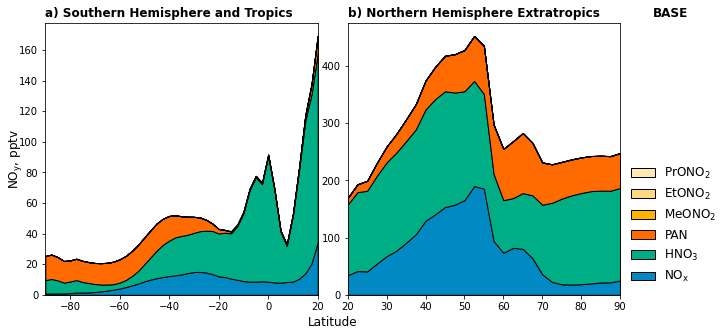

In [75]:
if var == 'noy':
    # Plot NOy partitioning over the Pacific
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10.3,5))
    ax[0].stackplot(meono2.coord('latitude').points[0:45], 
                 nox_pac_pbl_ann_ave.data[0:45], hno3_pac_pbl_ann_ave.data[0:45],
                 pan_pac_pbl_ann_ave.data[0:45], meono2_pac_pbl_ann_ave.data[0:45],
                 etono2_pac_pbl_ann_ave.data[0:45], 
                 nprono2_pac_pbl_ann_ave.data[0:45]+iprono2_pac_pbl_ann_ave.data[0:45], 
                 colors=[clr_nox, clr_hno3, clr_pan, clr_meono2, clr_etono2, clr_prono2],
                 edgecolor='k');
    ax[1].stackplot(meono2.coord('latitude').points[44:], 
                 nox_pac_pbl_ann_ave.data[44:], hno3_pac_pbl_ann_ave.data[44:],
                 pan_pac_pbl_ann_ave.data[44:], meono2_pac_pbl_ann_ave.data[44:],
                 etono2_pac_pbl_ann_ave.data[44:], 
                 nprono2_pac_pbl_ann_ave.data[44:]+iprono2_pac_pbl_ann_ave.data[44:],
                 colors=[clr_nox, clr_hno3, clr_pan, clr_meono2, clr_etono2, clr_prono2],
                 edgecolor='k',
                 labels=['$NO_x$', '$HNO_3$', 'PAN', '$MeONO_2$', '$EtONO_2$', '$PrONO_2$'])
    ax[0].set_title('a) Southern Hemisphere and Tropics', weight='bold', loc='left')
    ax[1].set_title('b) Northern Hemisphere Extratropics', weight='bold', loc='left')
    ax[1].set_title(exp, weight='bold', loc='right', x=1.25)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Latitude', fontsize=12)
    ax[0].set_ylabel('$NO_y$, pptv', labelpad=-5, fontsize=12)
    ax[0].set_xlim(-90,20)
    ax[1].set_xlim(20,90)
    if fisher2020bar:
        ax[0].set_ylim(0,100)
        ax[1].set_ylim(0,350)
    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend(reversed(handles), reversed(labels), frameon=False, bbox_to_anchor=(1, 0), loc='lower left', fontsize=12)
    fig.subplots_adjust(wspace=0.11)
    if savefig: 
        if fisher2020bar:
            fig.savefig(path_to_figs / f'Fisher2018-like_{exp.lower()}_{var}_partitioning.png', bbox_inches='tight', dpi=200)
        else:
            fig.savefig(path_to_figs / f'Fisher2018-like_{exp.lower()}_{var}_partitioning_diffbar.png', bbox_inches='tight', dpi=200)